In [1]:
#%%capture

import pandas as pd
import numpy as np
import scipy as sp
import plotly
import folium
import os

import plotly.io as pio
pio.renderers.default='notebook'

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets
from IPython.core.display import HTML
from IPython.display import display, clear_output
import datetime
from io import StringIO


import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import trianer

plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
races_configs = trianer.Race.load_races_configs()

In [3]:
athlete = trianer.Athlete(
        name="John Doe",
        config={
"swimming_sX100m":datetime.time(2, 35),
"cycling_kmXh":30,
"running_sXkm":datetime.time(5, 30),
"transition_swi2cyc_s":datetime.time(2, 0),
"transition_cyc2run_s":datetime.time(2, 0),
"weight_kg":70
},
    )
simulation = trianer.Triathlon(epreuve="Elsassman (L)", races_configs=races_configs, athlete=athlete, info_box=None)

2022-09-18 21:36:20.783 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            
2022-09-18 21:36:20.787 Initialized tornado logs
2022-09-18 21:36:20.788 
  command:

    streamlit run /opt/miniconda/envs/trianer_py3.10/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


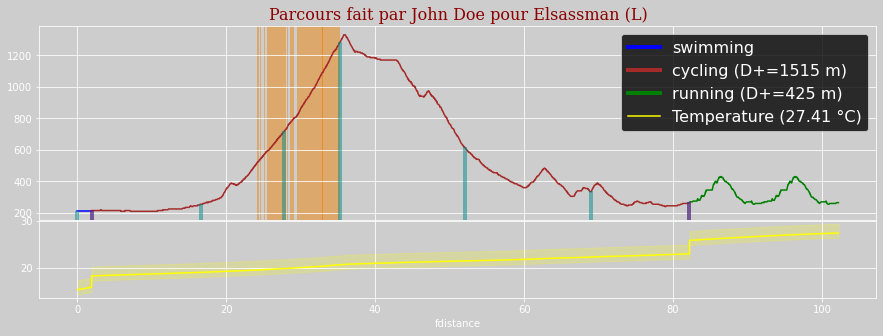

In [27]:
#simulation.show_race_details(xaxis="Expected time")
simulation.show_race_details(xaxis="fdistance")

#def show_race_details(triathlon, xaxis="fdistance"):
#        # xaxis = st.radio("x axis", ["Total distance", "Expected time of day", "Expected time"], horizontal=True)
#        if "Expected time" in xaxis:


In [4]:
# Dataframe to models
df_model_properties = pd.DataFrame({
    'Model':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all'],    
    'Features': [['t'],['t'],['t'],['t'],['t','h'],
                 ['t','h'],['t','h'],['t','h','T'],
                 ['t','h','T'],['t','h','T','A','W','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H']],
    'Regressors':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all']
}).set_index('Model')

display(df_model_properties)

for f in ['MAE_test', 'R2_test', 'MAE_train', 'R2_train']:
    df_model_properties[f] = ""
    

,Features,Regressors
Model,,
linear_t,[t],linear_t
quad_t,[t],quad_t
SPPM_t,[t],SPPM_t
DPPM_t,[t],DPPM_t
multlin_th,"[t, h]",multlin_th
multquad_th,"[t, h]",multquad_th
power_th,"[t, h]",power_th
multlin_tht,"[t, h, T]",multlin_tht
multquad_tht,"[t, h, T]",multquad_tht


In [5]:
# Import Calories Dataset
df_cal = pd.read_csv('kkcalories/calories.csv')

# Import Exercises Dataset
df_ex  = pd.read_csv('kkcalories/exercise.csv')

# Merging Datasets
df = pd.merge(df_ex, df_cal, on = 'User_ID')
df.head()

# Convert string to int
df['Gender'] = pd.get_dummies(df['Gender'], prefix_sep='_', drop_first=True)
df = df.drop(columns=['User_ID'], axis=1)

display(df.head())

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["Calories"]), df["Calories"], test_size=0.3)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0


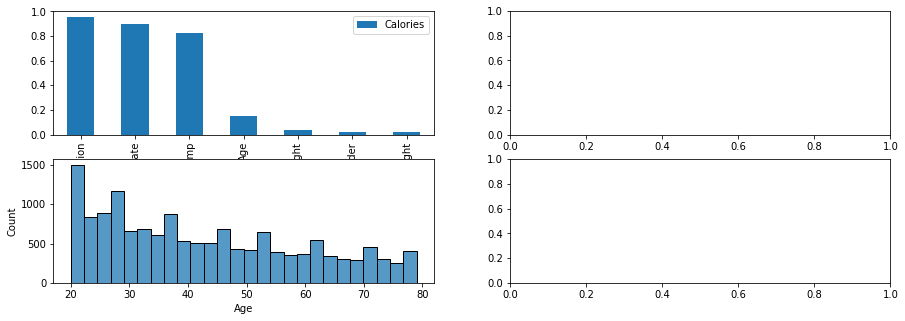

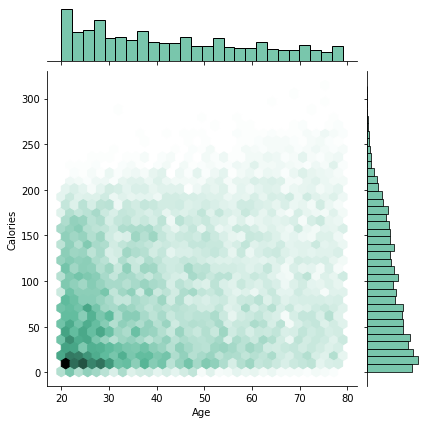

In [6]:
correlations = df.copy().corr()['Calories']
correlations = correlations.sort_values(ascending=False).drop('Calories', axis=0)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=2)

correlations.to_frame().plot.bar(ax=ax[0][0]);
sns.histplot(df['Age'], ax=ax[1][0])
#sns.displot(x='Gender', y='Calories', data=df, ax=ax[0][1]);

sns.jointplot(x='Age', y='Calories', data=df, kind="hex", color="#4CB391")

From here, it is possible to see that the features that most contribute to the total calory burned on exercises is the 'duration', the 'heart rate' and the 'body temperature'

Let's rename the variables as:

t  : Duration
h  : Heart_Rate
T  : Body_Temp
A  : Age
W  : Weight
G  : Gender
H  : Height
C  : Calories

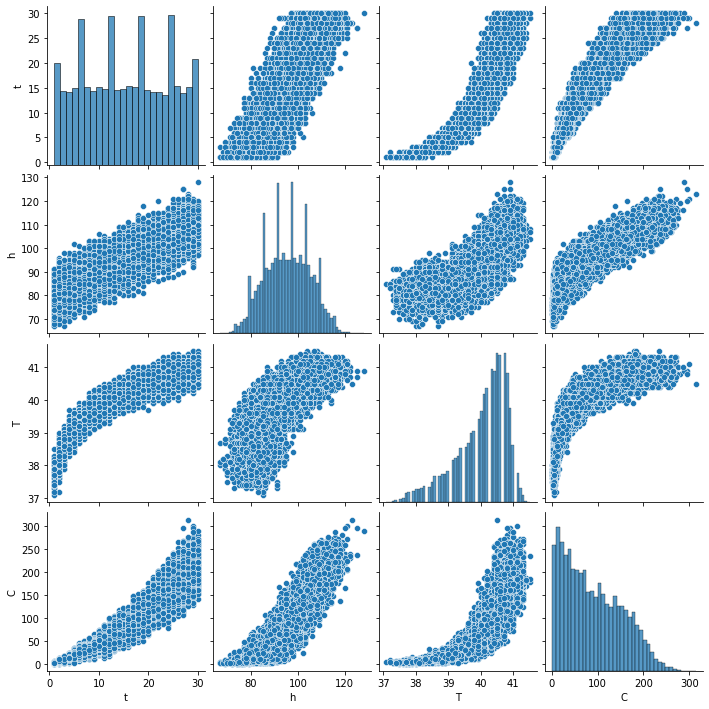

In [7]:
df_3f = df[['Duration','Heart_Rate','Body_Temp','Calories']].copy()
df_3f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Calories':'C'},inplace=True)


df_6f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Height','Calories']].copy()
df_6f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Height':'H',
                      'Calories':'C'},inplace=True)


df_7f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Gender','Height','Calories']].copy()
df_7f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

sns.pairplot(df_3f)

From the scatter graphics, it's possible to conclude that, despite the strong correlation between the variables  t  and  C , the relation between them is not trivially linear. It's possible that a quadratic regression approach can substantially reduce the errors. Another way to deal with this problem is with power law models. To do this, let's check the relation betweeen logs of variables.

## One Feature Regression

### Linear Model
### Quadratic Model
### Power Law Models
### Model Comparison

As a first step, let's calculate the regression relating Calories and Duration, that are the most correlated variables.

In [8]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task="regression",metric='rmse', time_budget=300)

[flaml.automl: 09-18 21:36:33] {2600} INFO - task = regression
2022-09-18 21:36:33.680 task = regression
[flaml.automl: 09-18 21:36:33] {2602} INFO - Data split method: uniform
2022-09-18 21:36:33.682 Data split method: uniform
[flaml.automl: 09-18 21:36:33] {2605} INFO - Evaluation method: cv
2022-09-18 21:36:33.683 Evaluation method: cv
[flaml.automl: 09-18 21:36:33] {2727} INFO - Minimizing error metric: rmse
2022-09-18 21:36:33.688 Minimizing error metric: rmse
[flaml.automl: 09-18 21:36:33] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
2022-09-18 21:36:33.692 List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 09-18 21:36:33] {3174} INFO - iteration 0, current learner lgbm
2022-09-18 21:36:33.695 iteration 0, current learner lgbm
[flaml.automl: 09-18 21:36:33] {3307} INFO - Estimated sufficient time budget=681s. Estimated necessary time budget=5s.
2022-09-18 21:36:3

[flaml.automl: 09-18 21:36:36] {3174} INFO - iteration 19, current learner xgboost
2022-09-18 21:36:36.507 iteration 19, current learner xgboost
[flaml.automl: 09-18 21:36:36] {3354} INFO -  at 3.2s,	estimator xgboost's best error=37.0801,	best estimator lgbm's best error=2.5072
2022-09-18 21:36:36.843  at 3.2s,	estimator xgboost's best error=37.0801,	best estimator lgbm's best error=2.5072
[flaml.automl: 09-18 21:36:36] {3174} INFO - iteration 20, current learner rf
2022-09-18 21:36:36.844 iteration 20, current learner rf
[flaml.automl: 09-18 21:36:37] {3354} INFO -  at 3.4s,	estimator rf's best error=9.2543,	best estimator lgbm's best error=2.5072
2022-09-18 21:36:37.104  at 3.4s,	estimator rf's best error=9.2543,	best estimator lgbm's best error=2.5072
[flaml.automl: 09-18 21:36:37] {3174} INFO - iteration 21, current learner rf
2022-09-18 21:36:37.106 iteration 21, current learner rf
[flaml.automl: 09-18 21:36:37] {3354} INFO -  at 3.7s,	estimator rf's best error=6.6587,	best estim

2022-09-18 21:36:43.150 iteration 40, current learner xgboost
[flaml.automl: 09-18 21:36:43] {3354} INFO -  at 9.8s,	estimator xgboost's best error=15.8072,	best estimator lgbm's best error=2.5072
2022-09-18 21:36:43.486  at 9.8s,	estimator xgboost's best error=15.8072,	best estimator lgbm's best error=2.5072
[flaml.automl: 09-18 21:36:43] {3174} INFO - iteration 41, current learner extra_tree
2022-09-18 21:36:43.487 iteration 41, current learner extra_tree
[flaml.automl: 09-18 21:36:43] {3354} INFO -  at 10.0s,	estimator extra_tree's best error=4.5529,	best estimator lgbm's best error=2.5072
2022-09-18 21:36:43.699  at 10.0s,	estimator extra_tree's best error=4.5529,	best estimator lgbm's best error=2.5072
[flaml.automl: 09-18 21:36:43] {3174} INFO - iteration 42, current learner lgbm
2022-09-18 21:36:43.701 iteration 42, current learner lgbm
[flaml.automl: 09-18 21:36:44] {3354} INFO -  at 10.6s,	estimator lgbm's best error=2.5072,	best estimator lgbm's best error=2.5072
2022-09-18 2

2022-09-18 21:36:58.567 iteration 61, current learner rf
[flaml.automl: 09-18 21:36:58] {3354} INFO -  at 25.2s,	estimator rf's best error=4.5150,	best estimator lgbm's best error=1.9021
2022-09-18 21:36:58.876  at 25.2s,	estimator rf's best error=4.5150,	best estimator lgbm's best error=1.9021
[flaml.automl: 09-18 21:36:58] {3174} INFO - iteration 62, current learner lgbm
2022-09-18 21:36:58.879 iteration 62, current learner lgbm
[flaml.automl: 09-18 21:37:09] {3354} INFO -  at 36.2s,	estimator lgbm's best error=1.9021,	best estimator lgbm's best error=1.9021
2022-09-18 21:37:09.904  at 36.2s,	estimator lgbm's best error=1.9021,	best estimator lgbm's best error=1.9021
[flaml.automl: 09-18 21:37:09] {3174} INFO - iteration 63, current learner extra_tree
2022-09-18 21:37:09.905 iteration 63, current learner extra_tree
[flaml.automl: 09-18 21:37:11] {3354} INFO -  at 37.4s,	estimator extra_tree's best error=2.7035,	best estimator lgbm's best error=1.9021
2022-09-18 21:37:11.072  at 37.4s

[flaml.automl: 09-18 21:37:31] {3174} INFO - iteration 82, current learner rf
2022-09-18 21:37:31.364 iteration 82, current learner rf
[flaml.automl: 09-18 21:37:32] {3354} INFO -  at 58.5s,	estimator rf's best error=3.5219,	best estimator lgbm's best error=1.9021
2022-09-18 21:37:32.174  at 58.5s,	estimator rf's best error=3.5219,	best estimator lgbm's best error=1.9021
[flaml.automl: 09-18 21:37:32] {3174} INFO - iteration 83, current learner rf
2022-09-18 21:37:32.176 iteration 83, current learner rf
[flaml.automl: 09-18 21:37:32] {3354} INFO -  at 58.9s,	estimator rf's best error=3.5219,	best estimator lgbm's best error=1.9021
2022-09-18 21:37:32.599  at 58.9s,	estimator rf's best error=3.5219,	best estimator lgbm's best error=1.9021
[flaml.automl: 09-18 21:37:32] {3174} INFO - iteration 84, current learner rf
2022-09-18 21:37:32.600 iteration 84, current learner rf
[flaml.automl: 09-18 21:37:34] {3354} INFO -  at 60.6s,	estimator rf's best error=3.3617,	best estimator lgbm's best 

[flaml.automl: 09-18 21:39:38] {3174} INFO - iteration 103, current learner lgbm
2022-09-18 21:39:38.461 iteration 103, current learner lgbm
[flaml.automl: 09-18 21:39:59] {3354} INFO -  at 206.1s,	estimator lgbm's best error=0.9035,	best estimator lgbm's best error=0.9035
2022-09-18 21:39:59.796  at 206.1s,	estimator lgbm's best error=0.9035,	best estimator lgbm's best error=0.9035
[flaml.automl: 09-18 21:39:59] {3174} INFO - iteration 104, current learner rf
2022-09-18 21:39:59.798 iteration 104, current learner rf
[flaml.automl: 09-18 21:40:03] {3354} INFO -  at 209.7s,	estimator rf's best error=3.2272,	best estimator lgbm's best error=0.9035
2022-09-18 21:40:03.336  at 209.7s,	estimator rf's best error=3.2272,	best estimator lgbm's best error=0.9035
[flaml.automl: 09-18 21:40:03] {3174} INFO - iteration 105, current learner lgbm
2022-09-18 21:40:03.340 iteration 105, current learner lgbm
[flaml.automl: 09-18 21:40:35] {3354} INFO -  at 241.9s,	estimator lgbm's best error=0.9035,	be

[flaml.automl: 09-18 21:41:00] {3354} INFO -  at 267.2s,	estimator xgb_limitdepth's best error=2.7975,	best estimator lgbm's best error=0.9035
2022-09-18 21:41:00.810  at 267.2s,	estimator xgb_limitdepth's best error=2.7975,	best estimator lgbm's best error=0.9035
[flaml.automl: 09-18 21:41:00] {3174} INFO - iteration 124, current learner xgboost
2022-09-18 21:41:00.812 iteration 124, current learner xgboost
[flaml.automl: 09-18 21:41:01] {3354} INFO -  at 267.6s,	estimator xgboost's best error=4.0312,	best estimator lgbm's best error=0.9035
2022-09-18 21:41:01.271  at 267.6s,	estimator xgboost's best error=4.0312,	best estimator lgbm's best error=0.9035
[flaml.automl: 09-18 21:41:01] {3174} INFO - iteration 125, current learner lgbm
2022-09-18 21:41:01.272 iteration 125, current learner lgbm
[flaml.automl: 09-18 21:41:13] {3354} INFO -  at 280.3s,	estimator lgbm's best error=0.9035,	best estimator lgbm's best error=0.9035
2022-09-18 21:41:13.943  at 280.3s,	estimator lgbm's best error

<class 'sklearn.linear_model._base.LinearRegression'> me (test): 8.430, R2 (test):  0.968, RMSE (test):  11.270
<class 'sklearn.linear_model._base.LinearRegression'> me (train): 8.351, R2 (train):  0.967, RMSE (train):  11.332
<class 'sklearn.ensemble._forest.RandomForestRegressor'> me (test): 1.976, R2 (test):  0.998, RMSE (test):  3.103
<class 'sklearn.ensemble._forest.RandomForestRegressor'> me (train): 0.782, R2 (train):  1.000, RMSE (train):  1.264
<class 'sklearn.tree._classes.DecisionTreeRegressor'> me (test): 3.485, R2 (test):  0.993, RMSE (test):  5.432
<class 'sklearn.tree._classes.DecisionTreeRegressor'> me (train): 0.000, R2 (train):  1.000, RMSE (train):  0.000
<class 'xgboost.sklearn.XGBRegressor'> me (test): 1.542, R2 (test):  0.999, RMSE (test):  2.199
<class 'xgboost.sklearn.XGBRegressor'> me (train): 0.929, R2 (train):  1.000, RMSE (train):  1.254


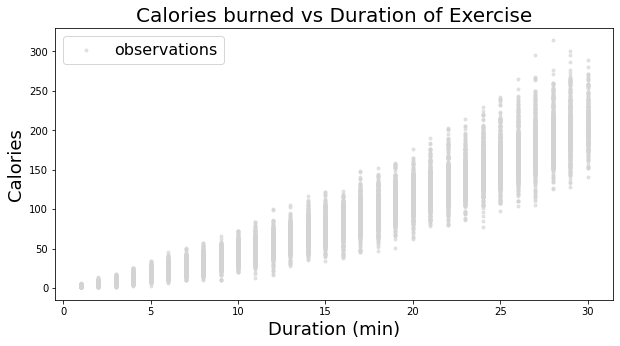

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

regressors = [linear_model.LinearRegression(), 
              RandomForestRegressor(n_estimators=30, random_state=42), 
              DecisionTreeRegressor(random_state=42), XGBRegressor()]

plt.figure(figsize=(10, 5))
plt.scatter(df['Duration'], df['Calories'],c='lightgray',label = 'observations',alpha = 0.6, marker='.',zorder=1)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

for reg in regressors:
    # Create a lineat regression object
    # reg = linear_model.LinearRegression()

    # Train the model using the training sets
    reg.fit(x_train, y_train)

    # Predictions for the test set
    p_test, p_train = reg.predict(x_test), reg.predict(x_train)

    mae_test = mean_absolute_error(y_test, p_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, p_test))
    r2s_test = r2_score(y_test, p_test)
    
    mae_train = mean_absolute_error(y_train, p_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, p_train))
    r2s_train = r2_score(y_train, p_train)
    
    # Printing  results
    print(f'{type(reg)} me (test): {mae_test:.3f}, R2 (test):  {r2s_test:.3f}, RMSE (test):  {rmse_test:.3f}')
    print(f'{type(reg)} me (train): {mae_train:.3f}, R2 (train):  {r2s_train:.3f}, RMSE (train):  {rmse_train:.3f}')

    # Plotting and comparing
    #plt.plot(np.linspace(t_i.min(), t_i.max(), 100), reg.predict(t_val.reshape(-1,1)), c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)

<AxesSubplot:>

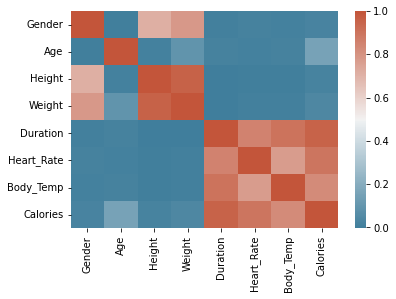

In [10]:
corr_matrix = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) 
sns.heatmap(corr_matrix, annot=False ,cmap=cmap)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scl = MinMaxScaler(feature_range = (0, 1))
#X = scl.fit_transform(X)
#X

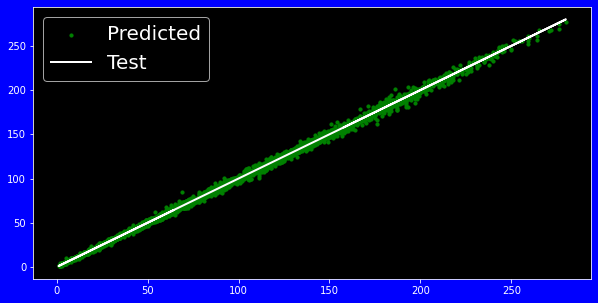

In [12]:
plt.style.use(['dark_background'])
fig = plt.figure(figsize=(10, 5),facecolor='b', edgecolor='g')
plt.scatter(y_test,p_test ,s=10,c='g',label='Predicted') 
plt.plot(y_test, y_test,'white' ,label='Test' ,linewidth=2.0)
plt.legend(fontsize=20)
plt.show()

In [13]:
print('MAE:', metrics.mean_absolute_error(y_test, p_test))  
print('MSE:', metrics.mean_squared_error(y_test, p_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, p_test)))
print('VarScore:',metrics.explained_variance_score(y_test, p_test))

score = reg.score(x_train, y_train)
percentage = "{:.0%}".format(score)

print('Acc_Score:',percentage)

MAE: 1.5421679765118492
MSE: 4.8335438986091175
RMSE: 2.1985322145943456
VarScore: 0.998781923657602
Acc_Score: 100%


In [14]:
trianer.hist_calories_per_sport()

2022-09-18 21:41:40.346 STREAM b'IHDR' 16 13
2022-09-18 21:41:40.347 STREAM b'sRGB' 41 1
2022-09-18 21:41:40.348 STREAM b'gAMA' 54 4
2022-09-18 21:41:40.349 STREAM b'pHYs' 70 9
2022-09-18 21:41:40.350 STREAM b'IDAT' 91 11717


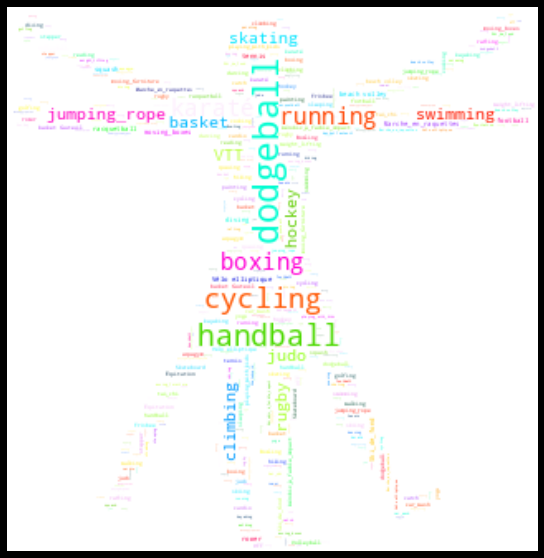

In [15]:
trianer.wordcloud_calories_per_sport()